In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq
from cosmocalc import dist
from pprint import pprint


In [2]:
def flux_data_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_subcube_par_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr,OIII_br,Hb1_blr_br,Hb2_blr_br) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_subcube_par_err_%s.fits'%(destination_path_cube,obj,obj))
    (OIII_nr_err,OIII_br_err,Hb1_blr_br_err,Hb2_blr_br_err) = (hdu[2].data,hdu[3].data,hdu[5].data,hdu[6].data)
    hdu.close()
    
    hdu = fits.open('%s/%s/%s_9_arcsec_empirical_factor_subcube.fits'%(destination_path_cube,obj,obj))
    central_tab = hdu[1].data
    central_columns = hdu[1].header
    (emp_Hb1,emp_Hb2) = (central_tab.field('emp_fact_Hb1')[0],central_tab.field('emp_fact_Hb2')[0])
    hdu.close()
    
    (amp_OIII_nr,amp_OIII_br,amp_Hb1_blr_br,amp_Hb2_blr_br) = (np.max(OIII_nr),np.max(OIII_br),np.max(Hb1_blr_br),np.max(Hb2_blr_br))
    if amp_Hb1_blr_br > amp_Hb2_blr_br:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb1_blr_br,amp_Hb1_blr_br,Hb1_blr_br_err,emp_Hb1)
    else:
        (Hb_blr_br,amp_Hb_blr_br,Hb_blr_err,emp_Hb_blr) = (Hb2_blr_br,amp_Hb2_blr_br,Hb2_blr_br_err,emp_Hb2)
    print (emp_Hb_blr)
    (blr_err_final,wing_err_final,core_err_final) = (emp_Hb_blr*Hb_blr_err,emp_Hb_blr*OIII_br_err,OIII_nr_err)
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,blr_err_final,wing_err_final,core_err_final
    

In [3]:
def remove_bad_pixel(data,err):
    data[data == 0.01] = 0
    err[err < 10**(-14)] =10**(10)  
    return data,err

In [4]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, A, B, C, alpha] = p 
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [A,B,C,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+(A*((x-x0)**2))+(B*((y-y0)**2))+(C*(x-x0)*(y-y0)))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [5]:
def elliptical_moffat_fit(data,error,box_size,amp,x0,y0,muse_sampling_size,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if fix_par is None:
        p= [amp,x0,y0,0.1,0.1,-0.00008,3]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out]= popt
        theta_out = 0.5*np.arctan(C_out/(A_out - B_out))
        a_out = np.sqrt(2/(A_out + B_out + np.sqrt(C_out**2 +(A_out - B_out)**2)))
        b_out = np.sqrt(2/(A_out + B_out - np.sqrt(C_out**2 +(A_out - B_out)**2)))
        [fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        par = [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out,a_out,b_out,theta_out,fwhm1_out,fwhm2_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
    model = mod_rav.reshape(box_size,box_size)
    residual = data-model
    res = (residual/error)

    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,0.1,0.1,-0.00008,3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC]= popt_MC
            theta_MC = 0.5*np.arctan(C_MC/(A_MC - B_MC))
            a_MC = np.sqrt(2/(A_MC + B_MC + np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            b_MC = np.sqrt(2/(A_MC + B_MC - np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            [fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            par_MC = [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC,a_MC,b_MC,theta_MC,fwhm1_MC,fwhm2_MC]   
            parameters_MC[:,l] = par_MC    
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            parameters_MC[:,l] = popt_MC    
    parameters_err = np.std(parameters_MC,1) 
    return par,parameters_err,model,res

In [6]:
def moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    final_data = np.append(full_data,[D_A,D_L,muse_sampling_size])
    final_error = np.append(full_error,[0,0,0])
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'A':3,'B':4,'C':5,'alpha':6,'a':7,'b':8,'theta':9,'fwhm1':10,'fwhm2':11,'amp_OIII_br':12,'x0_OIII_br':13,'y0_OIII_br':14,'amp_OIII_nr':15,'x0_OIII_nr':16,'y0_OIII_nr':17,'D_A':18,'D_L':19,'sampling_size':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[final_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[final_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def source_moffat_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/9_arcsec_moffat_table_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_moffat_table.fits'%(destination_path_cube,obj,obj),overwrite=True)


def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/9_arcsec_maps_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [7]:
def algorithm_script(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_dat,OIII_br_dat,OIII_nr_dat,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_error,OIII_br_error,OIII_nr_error) = flux_data_err(obj)
    (Hb_blr_br_data,Hb_blr_br_err) = remove_bad_pixel(Hb_blr_br_dat,Hb_blr_br_error)
    (OIII_br_data,OIII_br_err) = remove_bad_pixel(OIII_br_dat,OIII_br_error)
    (OIII_nr_data,OIII_nr_err) = remove_bad_pixel(OIII_nr_dat,OIII_nr_error)  
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    print (brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y)
    
    if box_size ==45:
        muse_sampling_size = 0.2
    else:
        muse_sampling_size = 0.4
  
    print (muse_sampling_size)
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,muse_sampling_size,None,100)
    print (Hb_par,Hb_error)
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,muse_sampling_size,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,muse_sampling_size,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (D_A,D_L) = dist(z, H0=70, WM=.286)
    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,D_A,D_L,muse_sampling_size,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    source_moffat_table(obj)
        
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

1.6783578
HE0108-4743
1.6783578
21 21
0.2


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in power
  after removing the cwd from sys.path.


[0.22470577808666287, 22.277951934040598, 21.304646739566138, 0.024157667616633884, 0.02522162525103377, 0.0013655290527549962, 2.4766339577206393, 6.255476936204649, 6.478757715132492, -0.4544480706442867, 7.1099656379791885, 7.363746234085323] [0.00369679 0.03734326 0.0316533  0.00149968 0.00160923 0.00063123
 0.08812738 0.20123296 0.20579326 0.29316373 0.09890194 0.09718881]
[ 0.59850023 21.53743825 21.44494154] [0.00358949 0.03640065 0.03729453]
[ 0.97939909 20.232041   21.44021503] [0.00325165 0.02099555 0.01632119]


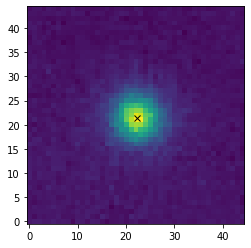

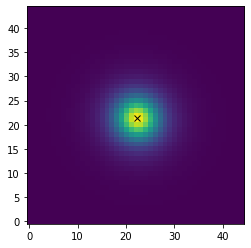

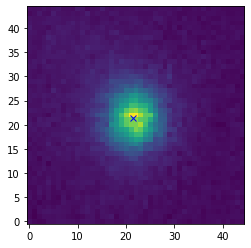

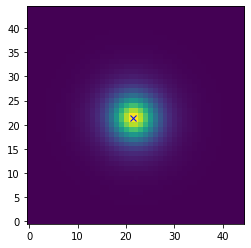

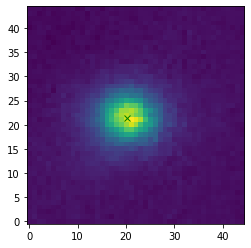

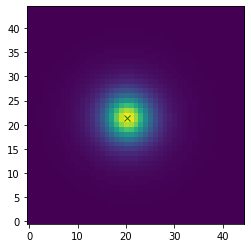

In [8]:
z = {"HE0108-4743":0.02392}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.5791438
HE0021-1819
1.5791438
21 22
0.2
[0.05794786929870938, 21.63782717011039, 22.119457979406324, 0.07358709299608661, 0.07859926072911537, -0.010943542865694714, 2.6938862752468795, 3.489778732385535, 3.7776266656960673, 0.5706538264104754, 3.780820648298105, 4.09267463483623] [0.00090173 0.01767025 0.01730821 0.00471072 0.00478238 0.00161677
 0.0948163  0.10809526 0.11868456 0.06976943 0.04927992 0.05442204]
[ 0.35804575 21.37772615 22.27985968] [0.00125886 0.00836394 0.00922618]
[ 1.95675552 21.47757013 22.00383355] [0.00219209 0.00257881 0.00284351]


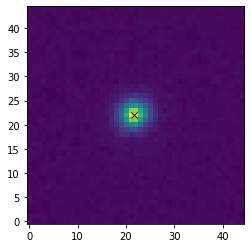

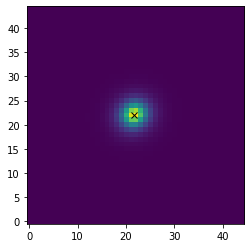

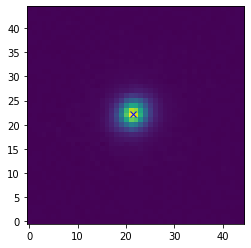

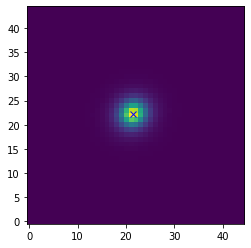

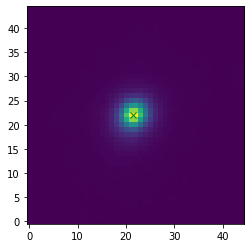

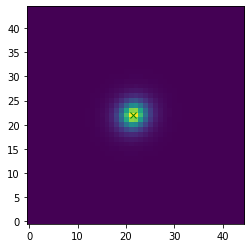

1.65103
HE0040-1105
1.65103
21 22
0.2
[0.3749291591527194, 21.649068344273807, 21.81411668548605, 0.08423823385953827, 0.09533301306014157, 0.00019322599525636405, 2.675043500422051, 3.2387425288246985, 3.4454626161936224, -0.008707089127611086, 3.5228492064260974, 3.7477030468467554] [0.00191691 0.00598674 0.00546699 0.00156545 0.00178815 0.00073671
 0.02896961 0.03035962 0.03208287 0.0328779  0.01489692 0.0148566 ]
[ 0.6425688  22.18112814 21.68158863] [0.00293783 0.01076127 0.00835713]
[ 3.98846093 21.45311152 22.01169551] [0.00471542 0.00359419 0.00313913]


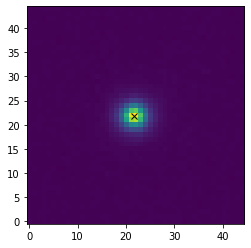

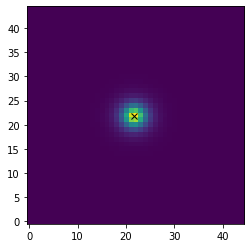

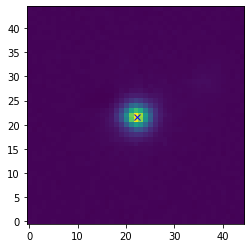

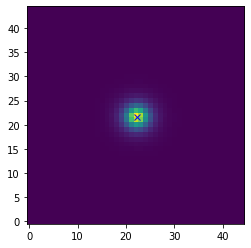

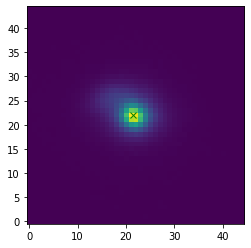

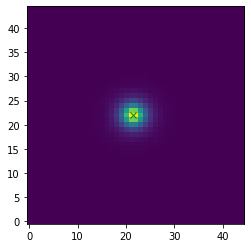

2.024678
HE0108-4743
2.024678
10 11
0.4
[1.2539189930511399, 11.053250204289546, 10.970140841571292, 0.10108228443108189, 0.10828960173604639, 0.0030681692615755368, 2.2874834838554716, 3.034450088417692, 3.150183051807517, -0.20123254111152855, 3.610551647329927, 3.7482569413508937] [0.03594301 0.03155239 0.03125226 0.01023425 0.01137875 0.00405904
 0.12640916 0.16002259 0.1715338  0.31536565 0.08549474 0.09592906]
[ 2.43915676 10.69821642 11.17585147] [0.02624228 0.03112696 0.04088163]
[ 7.2498739  10.15574596 11.09723849] [0.02330229 0.0098577  0.00831375]


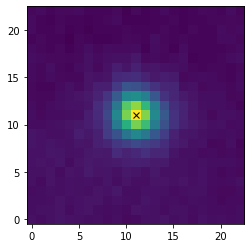

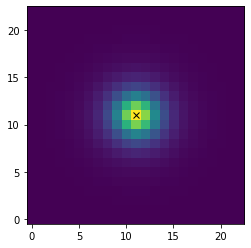

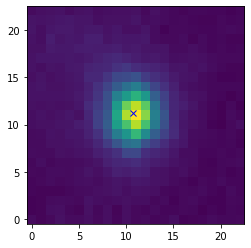

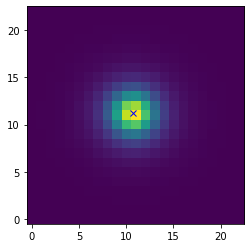

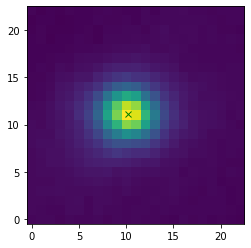

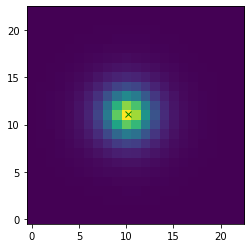

1.596306
HE0114-0015
1.596306
22 22
0.2
[0.1268598875168316, 21.63918658771033, 22.317403897458178, 0.08332449230318485, 0.09455872681638913, -0.015845792246402483, 3.695287146544028, 3.1837822531123026, 3.5526827881171363, 0.47703687463966576, 2.8923180300269706, 3.2274470004953666] [0.00344795 0.02308731 0.02366185 0.01168368 0.01329946 0.0036496
 0.34843063 0.21929804 0.25309621 0.09133054 0.0599665  0.07101283]
[ 0.09860971 21.93743435 23.4996495 ] [0.0039329  0.06832533 0.08731196]
[ 0.58872446 21.66666581 22.39509752] [0.00370643 0.01122287 0.01324679]


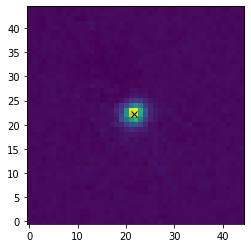

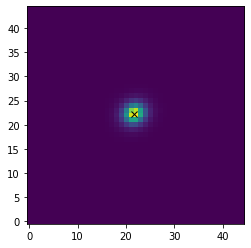

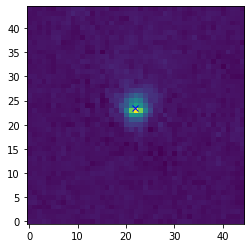

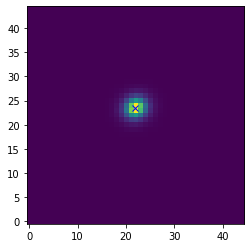

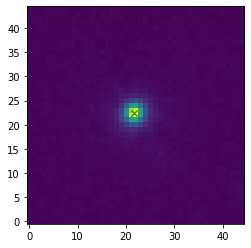

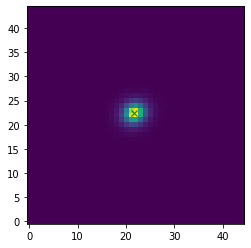

1.4236484
HE0119-0118
1.4236484
11 11
0.4
[1.7728537568393918, 11.107151832451839, 11.05897464339262, 0.38404682079438496, 0.4101007130435906, -0.0006402750129292196, 2.184462521325024, 1.5615383523732747, 1.6136529516450084, 0.01228503901355379, 1.9084665686358673, 1.9721595098286329] [0.050704   0.01618172 0.01485495 0.02714307 0.02718385 0.01079907
 0.0637965  0.05308477 0.05698398 0.21717295 0.03560084 0.03913308]
[ 9.52124182 11.03603063 10.97206432] [0.03188648 0.00400753 0.00417179]
[14.59409807 11.10429583 10.98855263] [0.03238707 0.00261643 0.0028532 ]


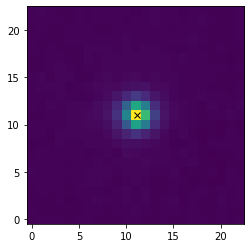

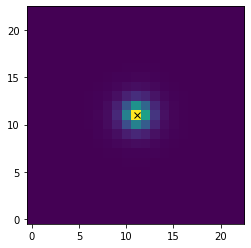

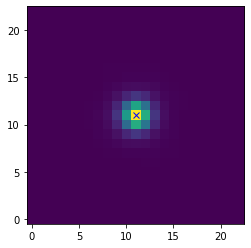

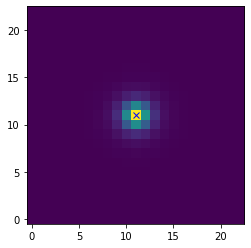

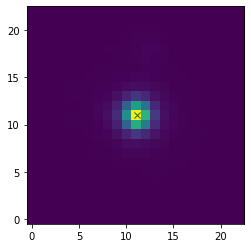

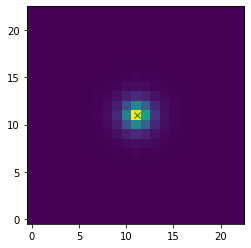

1.4469695
HE0212-0059
1.4469695
22 22
0.2
[0.25867732167284263, 22.28743778421987, 21.649773508638482, 0.10803501591449338, 0.10659851710494989, -0.00022615310670954128, 2.0401794772278485, 3.0422853724329078, 3.0629678620532177, -0.07807593797649387, 3.8702547100442284, 3.8965660165356484] [0.00621102 0.01649565 0.01622561 0.00397541 0.00385797 0.00144465
 0.02347876 0.05371449 0.05502567 0.40066474 0.04587911 0.04732677]
[ 0.20430969 22.45887448 23.07338824] [0.00470519 0.027709   0.08065763]
[ 2.37836219 22.30154727 21.58852033] [0.00355833 0.00306364 0.00339196]


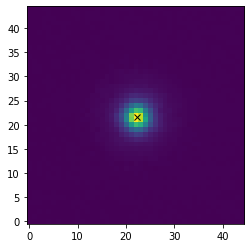

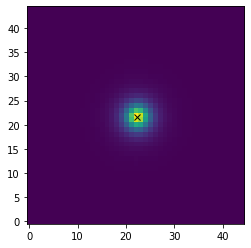

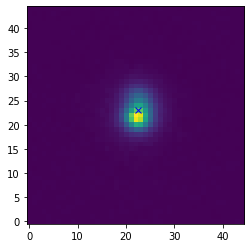

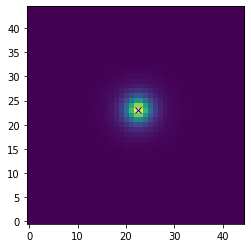

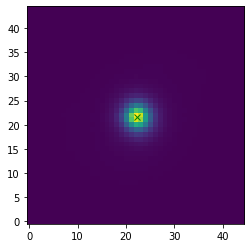

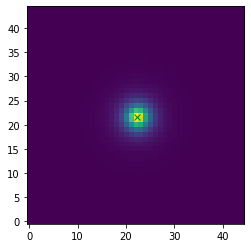

1.7291038
HE0224-2834
1.7291038
11 11
0.4
[0.3532542474968192, 10.889076506769005, 10.992845027736765, 0.057444633667917716, 0.05620806502326099, -0.0030368316969336226, 3.0794136382299047, 4.135699539117532, 4.256788591976515, -0.5920533791793967, 4.155801709872319, 4.277479333732189] [0.00203258 0.00727872 0.00699103 0.00156198 0.00149056 0.00044755
 0.05291131 0.05616884 0.05692955 0.07707863 0.02054667 0.0198267 ]
[ 0.99994033 10.93971315 10.92286111] [0.0048216  0.01109398 0.01075077]
[ 3.2162139  10.1231669  11.37728089] [0.00535795 0.00660711 0.00479037]


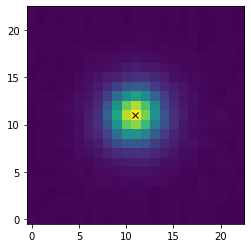

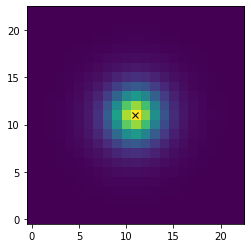

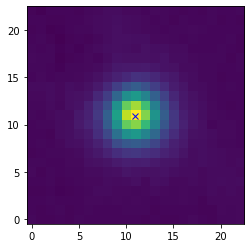

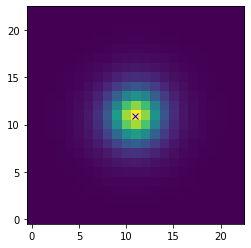

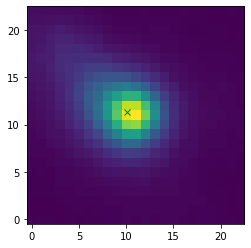

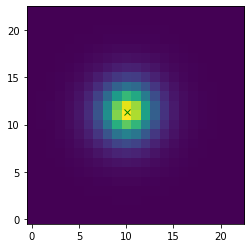

2.183495
HE0227-0913
2.183495
11 11
0.4
[7.3610713014682245, 11.001239648293305, 11.070108211371412, 0.13786262215378575, 0.13469640714570888, -0.0014902461430446943, 2.402752210158121, 2.691624650768803, 2.7264072150900147, -0.21995524219458273, 3.1129815698191483, 3.153209125935509] [0.04729517 0.00579496 0.00569233 0.00256578 0.00258244 0.00110462
 0.0222295  0.0250076  0.02660538 0.18257133 0.01420852 0.01593781]
[ 0.61989793 11.08538912 11.15954993] [0.00986815 0.02943117 0.02650305]
[ 6.47240848 11.025794   11.18339805] [0.00703105 0.00213818 0.00235325]


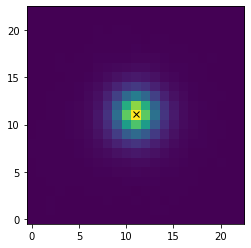

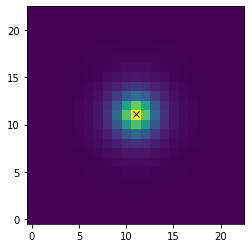

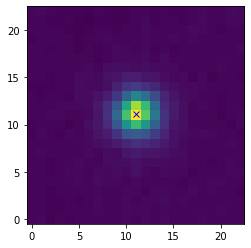

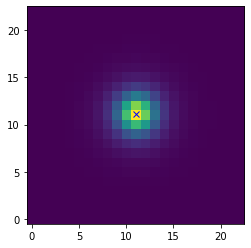

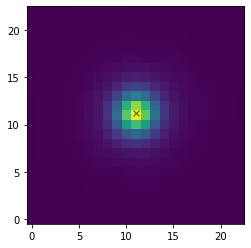

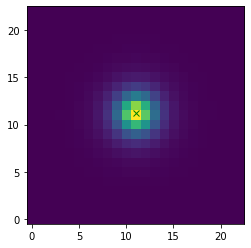

1.86127
HE0232-0900
1.86127
11 11
0.4
[7.841402705259553, 11.11012104690592, 11.118239979229717, 0.13862191513550132, 0.13664119604329633, -8.930507629117261e-06, 2.5105697222445715, 2.685864116073456, 2.705261105704118, -0.002254344684773284, 3.029047810023054, 3.0509232312739587] [0.06208256 0.00410642 0.00377878 0.0019187  0.00200632 0.00060048
 0.01494278 0.01853046 0.01983539 0.1588947  0.01191154 0.01293784]
[22.02927656 10.6674095  10.94823829] [0.08773621 0.00651827 0.00612859]
[53.85604524 11.03060179 10.30721134] [0.07455582 0.00160982 0.00293374]


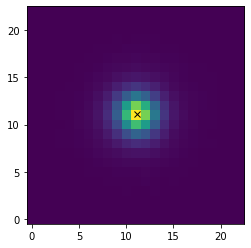

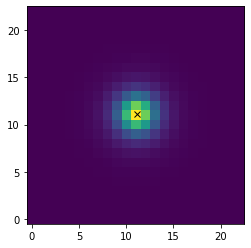

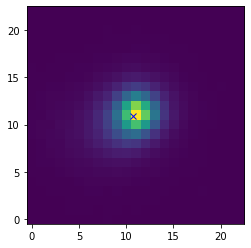

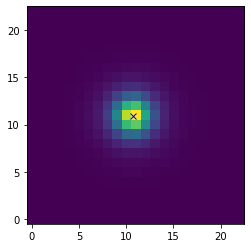

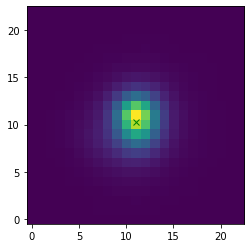

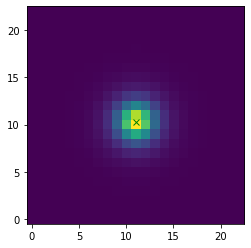

1.6383115
HE0253-1641
1.6383115
11 11
0.4
[2.792452533608944, 11.077202204898983, 10.769666152605707, 0.19147359012315757, 0.1715122872799013, 0.012963532290072341, 2.75397691821835, 2.273939501309204, 2.4282702286606064, 0.2879883233197522, 2.432994813493322, 2.598120516702414] [0.05699663 0.01002132 0.01180575 0.01139878 0.00985214 0.00295686
 0.08536453 0.06884519 0.07102019 0.07355948 0.03446309 0.0349256 ]
[ 7.08135027 11.01320064 10.79947726] [0.02263587 0.00446205 0.00431316]
[22.44159924 10.94405993 10.5384069 ] [0.02543345 0.00177274 0.00175607]


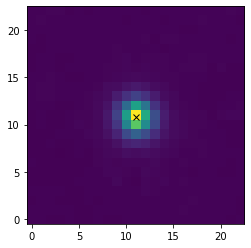

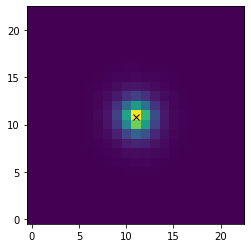

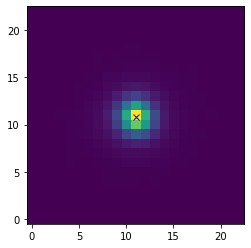

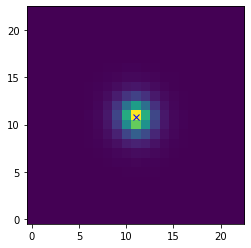

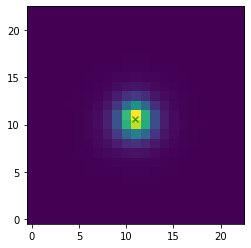

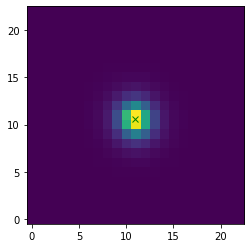

1.6202188
HE0345+0056
1.6202188
11 11
0.4
[30.76309985537401, 11.09585814542642, 11.0626685793034, 0.2412923240730056, 0.22946418255620032, 0.006014990831703368, 2.3882474502615207, 2.032734030490408, 2.0908636516350514, 0.23522502404774023, 2.359156923257643, 2.4266211837623213] [0.28910407 0.00392256 0.00410615 0.00349776 0.00321353 0.00120757
 0.01189123 0.01490816 0.01451767 0.04167488 0.01140035 0.0108214 ]
[12.26869913 11.1039767  11.00903694] [0.03529904 0.0036544  0.00418766]
[23.50763297 11.09835756 10.95157095] [0.032445   0.00212629 0.00229905]


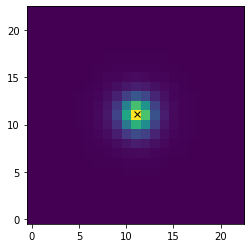

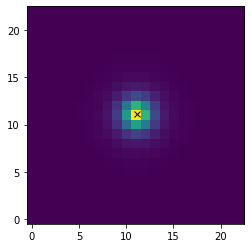

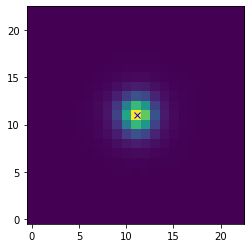

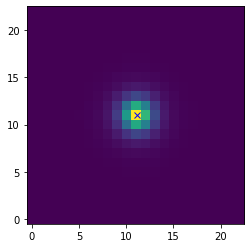

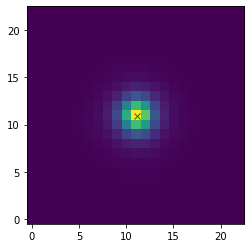

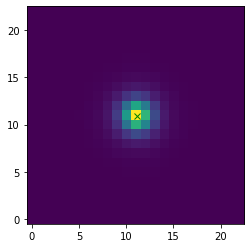

1.5067376
HE0351+0240
1.5067376
11 11
0.4
[3.760390286382133, 10.940180873615372, 10.718726862461391, 0.2315605301380038, 0.20536922983243855, -0.004085228087400968, 3.0154469988227817, 2.0773960256383983, 2.207495368257996, -0.07736488815598057, 2.112133472819338, 2.244408288476694] [0.02235471 0.00368356 0.00408304 0.00640365 0.00545973 0.00181954
 0.05036292 0.02887141 0.02936276 0.03362141 0.01115538 0.01079839]
[ 2.32188452 10.91068952 10.72924286] [0.01961333 0.01512967 0.01434631]
[43.57648143 10.96786238 10.70259925] [0.04022218 0.00109642 0.00123275]


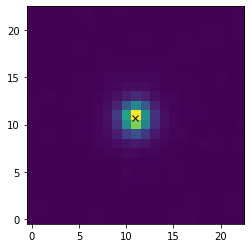

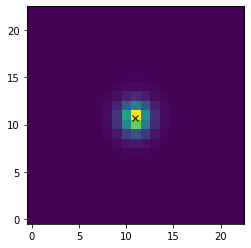

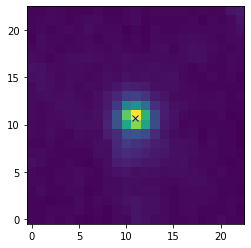

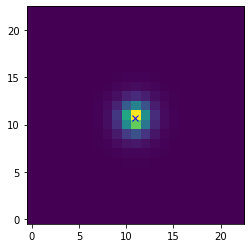

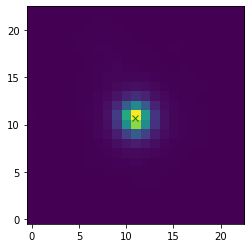

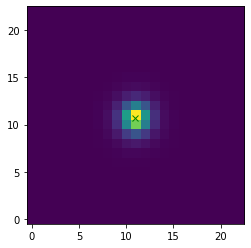

1.4144753
HE0412-0803
1.4144753
22 22
0.2
[1.6534149035609262, 21.961477581643795, 21.956799277915668, 0.09071426662091085, 0.09397248441770702, 0.010716551679227014, 2.3610179644523464, 3.19529863319087, 3.395337767445417, -0.6378204403139605, 3.733007120457646, 3.966709067682746] [0.00425836 0.00223731 0.0023371  0.00049642 0.0005443  0.00022379
 0.00582984 0.008978   0.00963932 0.00943569 0.00586724 0.00647819]
[ 5.69289236 22.14491915 21.9828941 ] [0.00774593 0.00381343 0.00368162]
[64.11913115 22.40154075 22.01401349] [0.02664365 0.00146107 0.00178336]


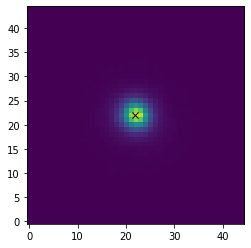

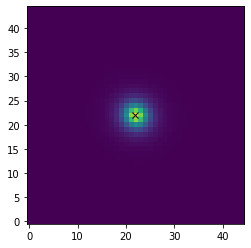

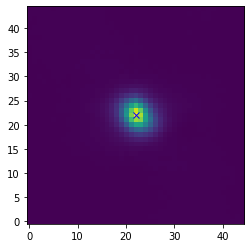

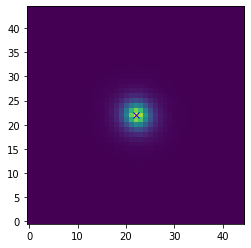

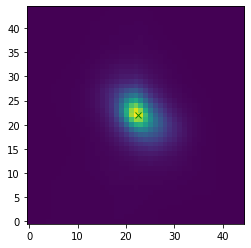

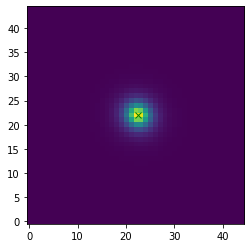

1.2741908
HE0429-0247
1.2741908
11 11
0.4
[1.9047288208116235, 11.08608387765402, 10.816421008809913, 0.21734265150073284, 0.2042853033194087, -0.003455023175494432, 2.326144900272421, 2.1438932198089344, 2.213708347185937, -0.12933771822920762, 2.5262897813739214, 2.608557518054183] [0.02719445 0.00932955 0.00989046 0.00906098 0.00858442 0.00320138
 0.04810577 0.04484522 0.04644576 0.11266492 0.02502064 0.02667837]
[ 2.20917738 11.21405891 10.79202923] [0.01082136 0.0072877  0.00727483]
[11.39561959 10.83585302 10.85865913] [0.01454346 0.00225375 0.00209409]


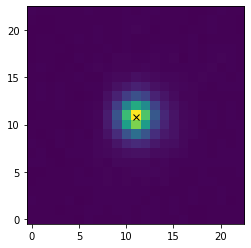

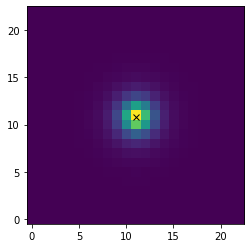

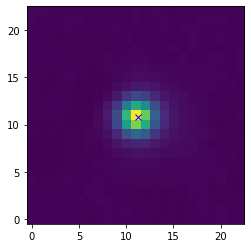

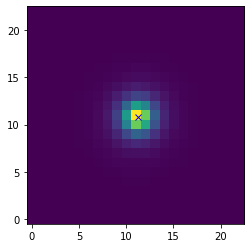

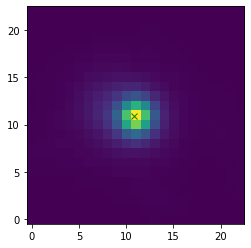

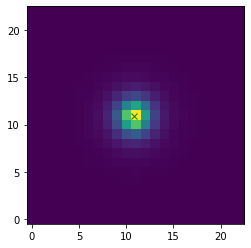

1.2863921
HE0433-1028
1.2863921
22 22
0.2
[2.664383507854443, 21.79323871883083, 22.12436647090282, 0.1543699264088099, 0.15475250401989027, -0.001617766866901733, 2.180499235370443, 2.5367934032576542, 2.550472567823433, 0.6692887709126895, 3.103682292904157, 3.1204182954457944] [0.02274256 0.00508389 0.0055696  0.00244714 0.00247296 0.00086828
 0.01344626 0.01997021 0.02024336 0.5474886  0.01463405 0.01511325]
[ 5.32820074 21.88607351 22.03141219] [0.00735628 0.00284922 0.00277239]
[ 5.40058209 21.83838684 22.21566254] [0.00873197 0.00306691 0.00359562]


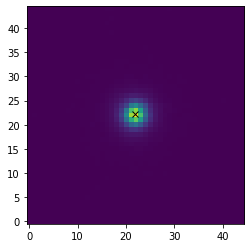

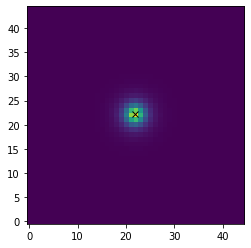

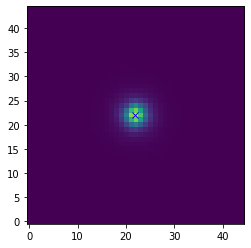

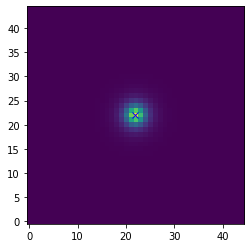

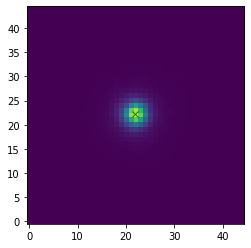

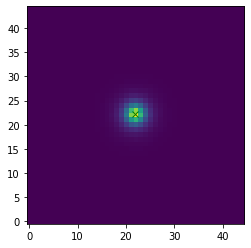

1.4686188
HE0853+0102
1.4686188
22 22
0.2
[0.188533561824347, 21.94494707344252, 22.316877368398544, 0.11442183779993191, 0.10568269021277339, -0.009927978451312443, 3.3814644599913675, 2.9277153565858964, 3.1092647340259982, -0.424499036053319, 2.7928981303049545, 2.9660874110421966] [0.00236273 0.01026079 0.01086337 0.00634099 0.0060736  0.00183615
 0.12588697 0.08018354 0.09045337 0.06902304 0.02438235 0.02978749]
[ 0.32340632 21.9825018  22.25381147] [0.00229747 0.00972287 0.01182193]
[ 1.13314488 22.15225941 22.49330082] [0.00329597 0.0045422  0.00476133]


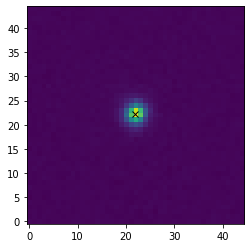

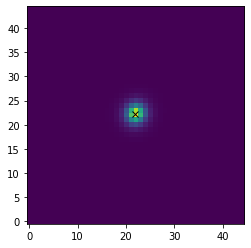

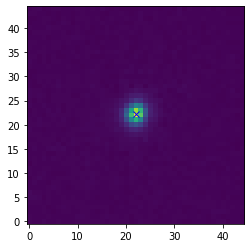

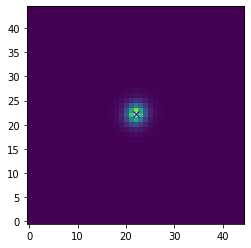

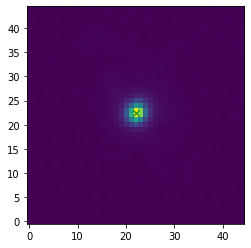

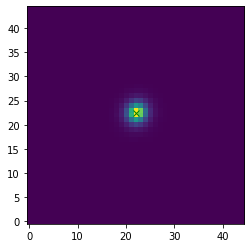

2.282569
HE0934+0119
2.282569
22 22
0.2
[0.9268482563244124, 21.532100631974032, 21.574300492004838, 0.10241996174982038, 0.10409593422938786, -0.00034328979503065853, 2.24289526346787, 3.0991801789120497, 3.1249608873603263, 0.10101782457155263, 3.729943221408224, 3.7609709684795507] [0.0117357  0.01209589 0.01346811 0.00317413 0.00307949 0.00130311
 0.02948887 0.04700946 0.04652037 0.34999562 0.03157539 0.03087386]
[ 1.00970508 21.62972826 21.41846363] [0.00538595 0.01290966 0.01106451]
[ 2.2737075  21.44092513 21.61099887] [0.00389867 0.00364322 0.00464596]


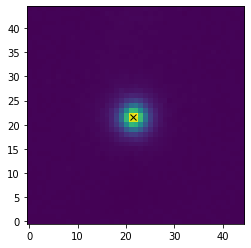

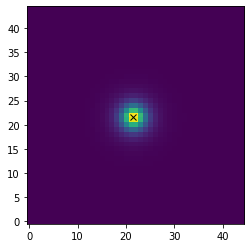

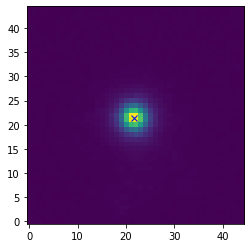

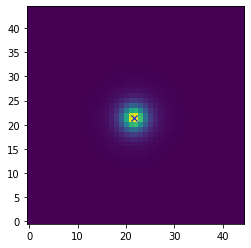

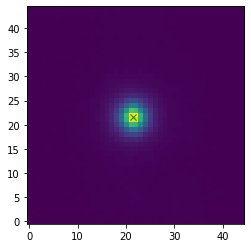

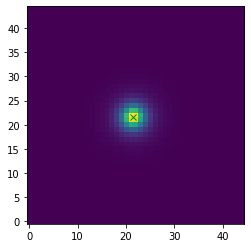

1.6742551
HE1011-0403
1.6742551
22 22
0.2
[0.8419139012220499, 21.775686561005692, 21.842481196174873, 0.08546976678039908, 0.08392719321217167, -0.0011983409611055198, 2.2846254877475243, 3.4164302433266363, 3.4560554455378356, -0.33023093723515484, 4.067998919497657, 4.115181290656823] [0.00815994 0.01033614 0.01142384 0.0021863  0.00206666 0.00099042
 0.02690229 0.04316819 0.04264983 0.28988217 0.02758912 0.02617945]
[ 0.5637114  21.84106586 21.83406053] [0.00294063 0.01309294 0.01391941]
[ 1.28942299 21.74519084 21.78868167] [0.00260379 0.00536899 0.00638366]


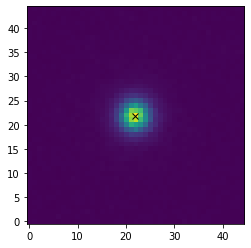

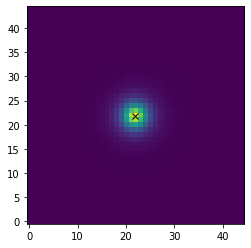

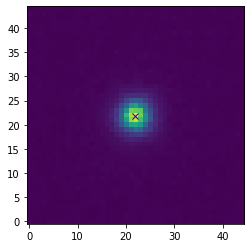

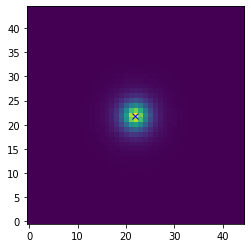

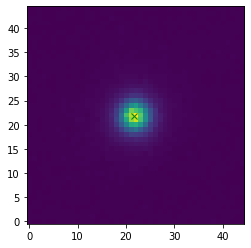

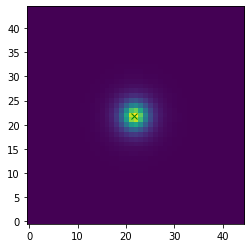

1.5528755
HE1017-0305
1.5528755
22 22
0.2
[0.691488709385072, 22.15123350750067, 21.98772015229191, 0.0775787249965706, 0.08490279296865355, 0.0021316565584788647, 2.613106461399722, 3.428867701530976, 3.5938042518620588, -0.1416120026118637, 3.779646314094865, 3.961456135523686] [0.00410611 0.00620582 0.00556677 0.0015159  0.00171993 0.00061029
 0.02854062 0.03463423 0.03546492 0.04002648 0.0168034  0.01705121]
[ 0.54725273 22.20999453 21.82280978] [0.00585306 0.02215871 0.02693447]
[ 1.39520473 22.10439566 22.05229278] [0.0060266  0.01009064 0.00972161]


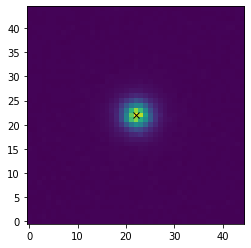

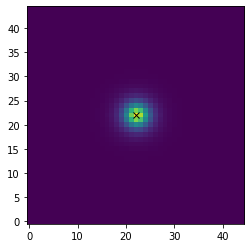

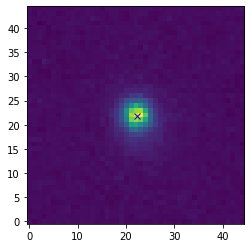

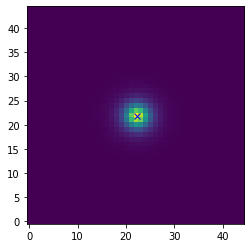

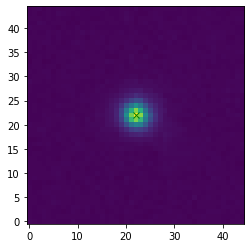

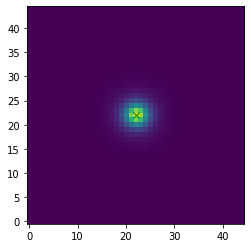

1.6701672
HE1029-1831
1.6701672
22 22
0.2
[0.37672452719370686, 21.882238036077897, 22.22140547583696, 0.08252080672007149, 0.08787351843104345, 0.003816711795842567, 2.5582466837662636, 3.3617630763629975, 3.4940670981968127, -0.30971294917415976, 3.7507665763371922, 3.8983800433594222] [0.0069641  0.02023674 0.0201662  0.00480285 0.00543759 0.00203171
 0.07726791 0.10053962 0.10194338 0.1878735  0.05650404 0.05587876]
[ 1.63111182 21.631907   22.51025881] [0.00551438 0.00955891 0.01043893]
[ 0.45061819 22.31801133 22.07976969] [0.00433412 0.02019753 0.02528941]


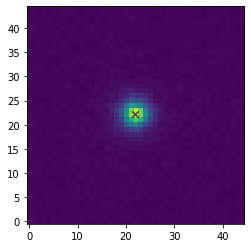

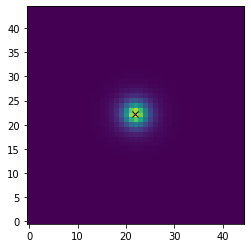

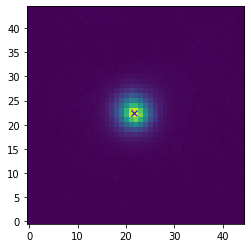

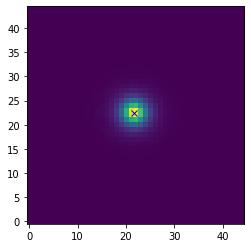

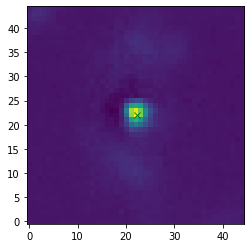

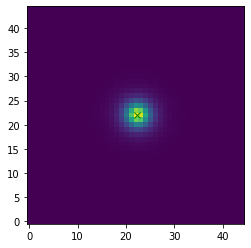

1.3343713
HE1107-0813
1.3343713
22 22
0.2
[0.9535957367616259, 21.861558809835383, 21.927816372923715, 0.11488420953434313, 0.1156362462492465, -0.013147435114857128, 2.41777365521336, 2.8648157445881894, 3.0334276921152434, 0.7568291639699691, 3.301425547943978, 3.495734655713289] [0.01507222 0.01102144 0.01059929 0.00351542 0.00365943 0.00150159
 0.03004911 0.04489789 0.04684361 0.69875678 0.03090135 0.03202686]
[ 0.14169735 22.03642259 21.98807841] [0.00278537 0.04775689 0.0422444 ]
[ 0.54774737 21.04614937 21.60709305] [0.00505234 0.02461687 0.01448988]


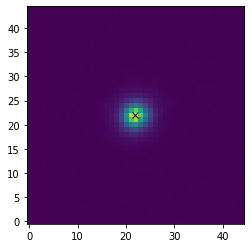

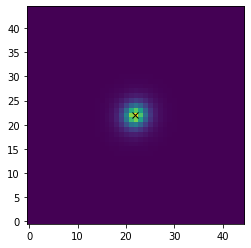

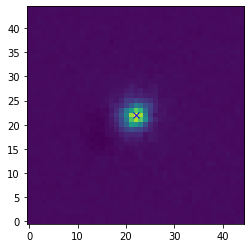

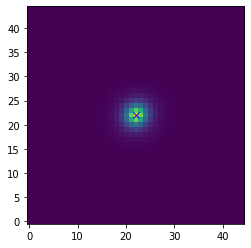

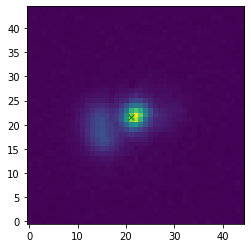

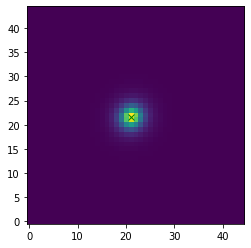

1.8106674
HE1108-2813
1.8106674
22 22
0.2
[1.617763971322878, 21.899543394990708, 22.449176609543237, 0.20726614259153253, 0.20707315978006893, 0.014653731884993894, 2.5062685437677525, 2.1591819172482305, 2.236950909073688, 0.7788137773387498, 2.4374598912170637, 2.525251844660488] [0.01225341 0.00493238 0.00532614 0.00442218 0.0048677  0.00190623
 0.02862617 0.02426655 0.0248889  0.73114279 0.01375808 0.01365158]
[ 2.13020348 22.19805971 22.47344137] [0.0135692  0.00971665 0.01021517]
[ 4.72183561 22.21676737 22.40649644] [0.01486306 0.00548993 0.00460786]


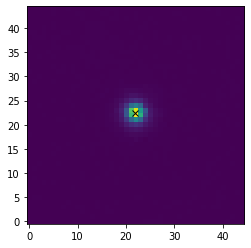

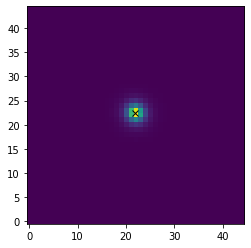

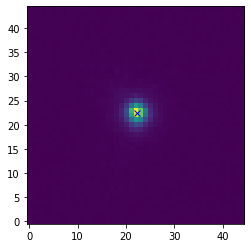

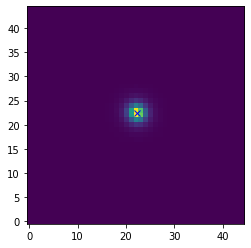

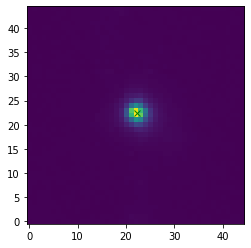

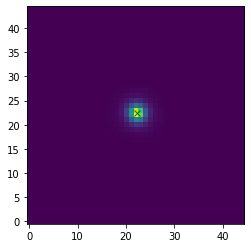

1.703259
HE1126-0407
1.703259
11 11
0.4
[11.4419347731302, 10.852721032058877, 11.093227718146673, 0.3210808840597684, 0.3148252026335398, -0.016154006750522858, 2.4501038744881383, 1.749775166882067, 1.7981088087341957, -0.600663570179113, 2.0011167734175577, 2.056393167357357] [0.17839282 0.00659471 0.00678664 0.00913912 0.0083178  0.00288959
 0.02740155 0.02455522 0.02441588 0.2391307  0.01665784 0.01614077]
[ 3.05798647 10.92299267 11.09253839] [0.03549693 0.01347077 0.0136404 ]
[22.29492639 11.0262716  11.43438816] [0.04507634 0.00209662 0.00265542]


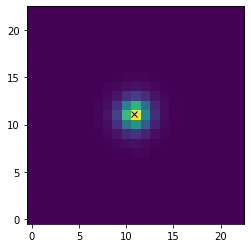

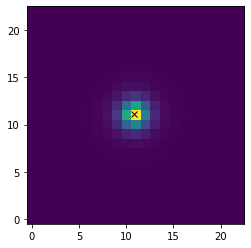

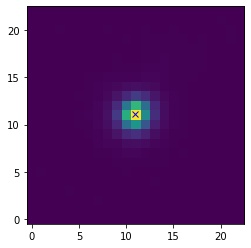

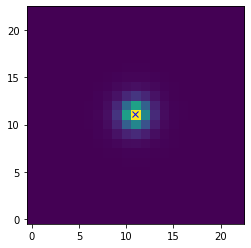

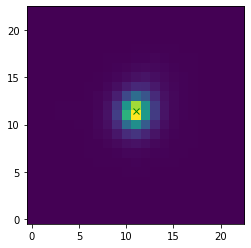

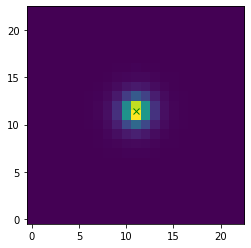

2.2641804
HE1237-0504
2.2641804
22 22
0.2
[2.597603695552867, 21.58818402846122, 22.268973099532914, 0.15426549291078936, 0.15784585501230244, 0.007577775399062114, 2.336268665722334, 2.498078863390855, 2.5660843372253277, -0.5647022483707287, 2.936270197950933, 3.016204602362269] [0.00513123 0.00158215 0.00154333 0.00075416 0.00082542 0.00031556
 0.00557505 0.00630515 0.0065629  0.01744941 0.00385114 0.00421587]
[ 2.03973318 21.41933479 22.23925915] [0.00457427 0.00378583 0.00473196]
[15.68008604 21.99746789 22.35501957] [0.0051318  0.00078235 0.00066394]


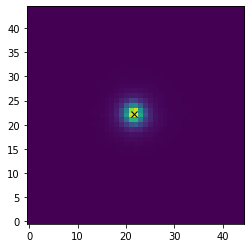

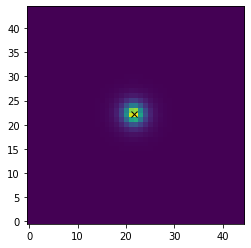

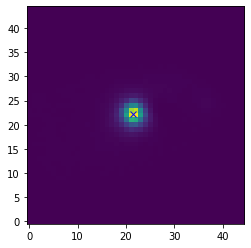

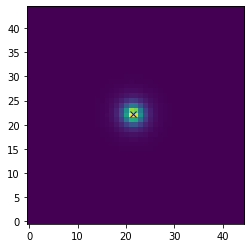

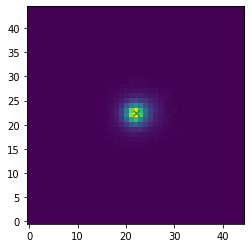

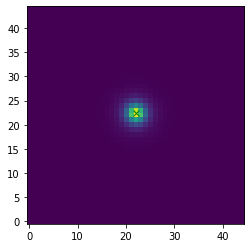

1.7083539
HE1248-1356
1.7083539
22 22
0.2
[0.16646495492636953, 22.255857636951653, 21.626143661881212, 0.08063338766190078, 0.07543955271385576, -0.0038575229532672225, 4.073741193905133, 3.507772395117758, 3.6563219431961276, -0.31941018786922665, 3.021433913390577, 3.1493876663215055] [0.00295853 0.01521    0.01950993 0.01082651 0.00992553 0.00278558
 0.42720927 0.24204388 0.25479338 0.21775965 0.05154071 0.05330649]
[ 0.63756763 22.37022301 21.52526842] [0.00573631 0.02176187 0.02044624]
[ 4.67770044 22.579987   21.57698309] [0.00785713 0.00334957 0.00329611]


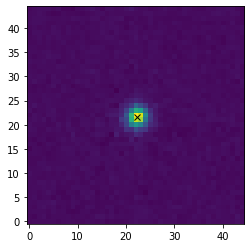

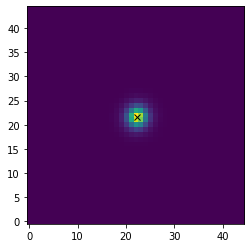

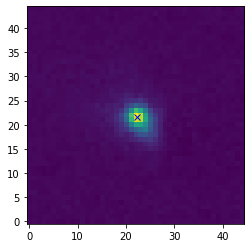

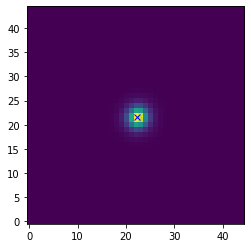

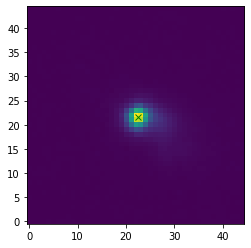

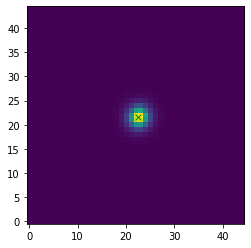

1.5505368
HE1330-1013
1.5505368
22 22
0.2
[0.31545079607533855, 21.643467384414024, 21.844144535100163, 0.10100615866129374, 0.09903876974311844, 0.002559090449825331, 2.334566801548314, 3.1367166960863506, 3.187745937984879, 0.45769058433797716, 3.6884852400473913, 3.748490852217713] [0.00705661 0.01880383 0.02086766 0.00761733 0.00722441 0.00265647
 0.08394851 0.11467321 0.11406354 0.42489675 0.06568256 0.06368281]
[ 0.15179763 21.48315013 22.04736285] [0.00299569 0.03788709 0.04153454]
[ 0.74959374 21.82146955 21.63028937] [0.00312731 0.01316058 0.01078401]


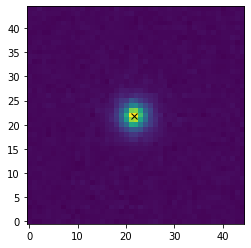

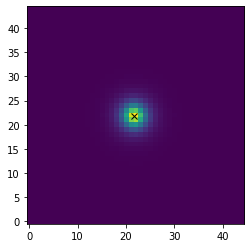

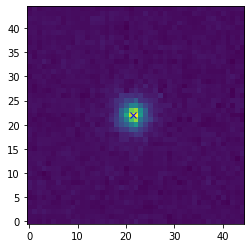

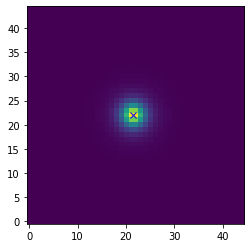

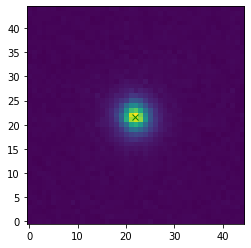

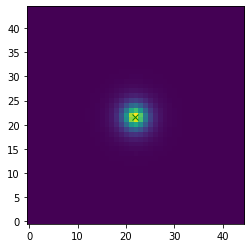

1.5331595
HE1353-1917
1.5331595
22 23
0.2
[0.12761202669594526, 22.470200232237808, 21.534000848428267, 0.07021192319910219, 0.07383814988881589, 0.00040165847902265395, 2.7072360895929357, 3.6798235088417846, 3.7742343422611215, -0.05515758811083095, 3.975557983161201, 4.077556283241436] [0.0018602  0.02077332 0.01815952 0.00350162 0.00379896 0.00160146
 0.0744918  0.09400821 0.09549737 0.26015543 0.04783759 0.04827782]
[ 0.16361747 25.57007957 16.99418466] [0.00115651 0.02463958 0.02857045]
[ 1.58678942 22.41168128 23.17629696] [0.00414308 0.0087131  0.01539851]


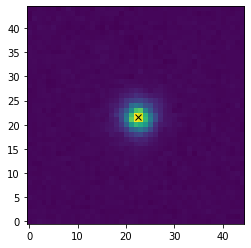

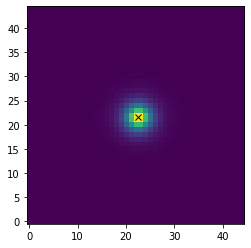

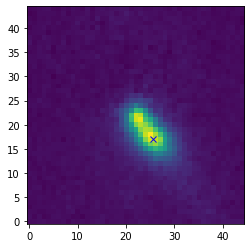

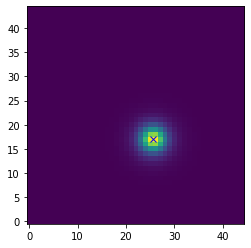

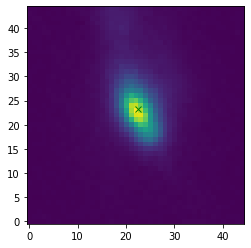

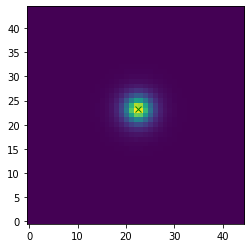

1.4668126
HE1417-0909
1.4668126
11 11
0.4
[1.6504436491036214, 11.204413069664414, 11.160620575368867, 0.30004732255207656, 0.28066463217661586, 0.021556761584419343, 2.5675557945931513, 1.811158398805255, 1.9039459291583698, 0.41922643931474723, 2.016550828459361, 2.1198608268160486] [0.01306122 0.00279632 0.00331138 0.00532877 0.00529375 0.00172777
 0.02264104 0.01646353 0.01742218 0.02800561 0.00936232 0.01022988]
[ 3.08915952 11.29979259 11.10082123] [0.02102927 0.00863157 0.00764031]
[15.18765055 11.21494621 11.1788818 ] [0.02778537 0.00186335 0.00222727]


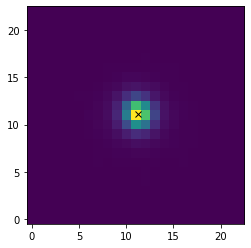

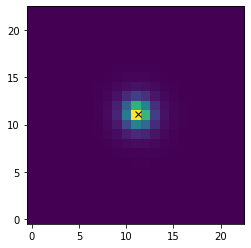

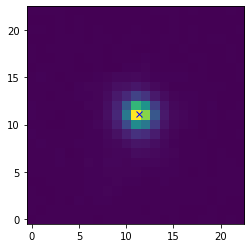

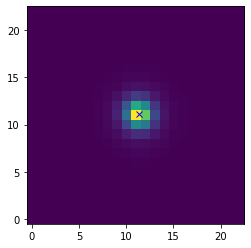

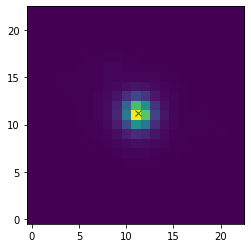

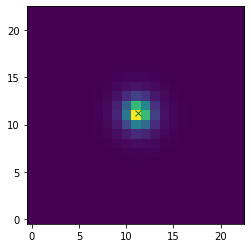

1.6032064
HE2128-0221
1.6032064
22 22
0.2
[0.25109783608054714, 21.66088768634062, 21.46708739280719, 0.0841531696791579, 0.08246850337970396, 0.0008638174501800954, 2.6486545451241987, 3.4450525709903963, 3.4844215216753796, 0.23689888154415364, 3.768414750858669, 3.8114789803384728] [0.00200606 0.00792224 0.00756354 0.00259691 0.00254934 0.00092631
 0.04491415 0.05218959 0.05397142 0.26627624 0.02354583 0.02579458]
[ 0.43597488 21.67920348 21.61971871] [0.00358039 0.02180369 0.01843424]
[ 1.78076127 21.70653251 21.71102441] [0.00424874 0.00583862 0.00690599]


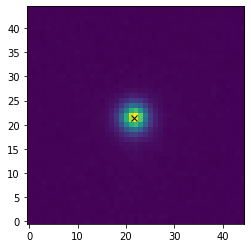

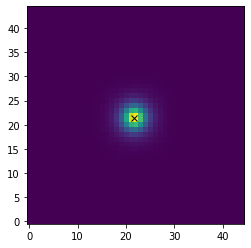

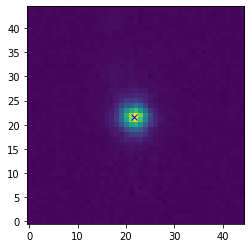

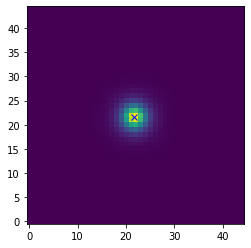

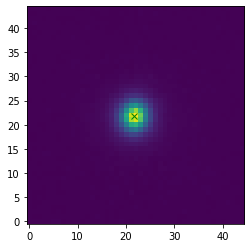

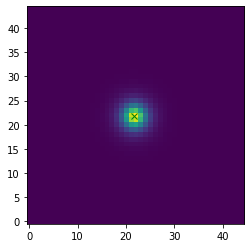

1.8839223
HE2211-3903
1.8839223
22 22
0.2
[0.3850586668833756, 22.361365086723783, 21.829075741069634, 0.14945323171376593, 0.1371688295480377, -0.008738277359070136, 2.862655633768636, 2.5747155580729775, 2.7138926643884425, -0.3091451598788031, 2.695299524854115, 2.840994837622335] [0.00256094 0.0059879  0.00585084 0.00387574 0.00338824 0.00150784
 0.0420484  0.03342876 0.03290666 0.05002873 0.01587843 0.01436235]
[ 0.14773161 22.54004026 22.1032741 ] [0.00392612 0.05042787 0.04095294]
[ 3.71314901 22.33031385 22.03690701] [0.00445165 0.00215843 0.00215448]


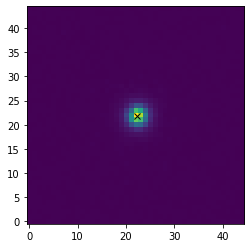

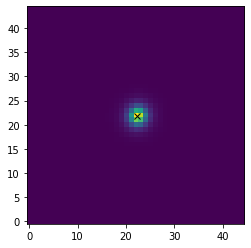

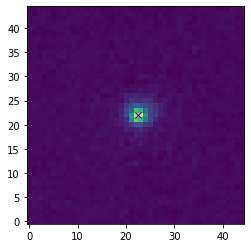

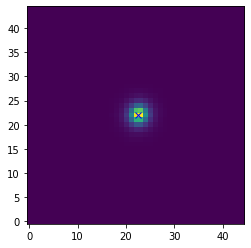

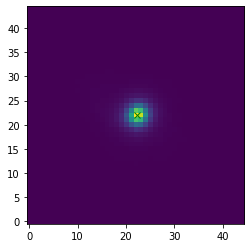

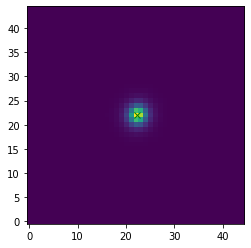

1.6778036
HE2222-0026
1.6778036
22 22
0.2
[0.18094653919456627, 21.851163201822956, 21.934904742763703, 0.09266009696379254, 0.0973128935984038, -0.004837736805282759, 2.5856246310900546, 3.188814702594843, 3.303543996338323, 0.40244125097309313, 3.5362684487338933, 3.6634986641742726] [0.00285241 0.01285076 0.01229534 0.0040696  0.00450357 0.00146896
 0.06046696 0.07348564 0.07288815 0.11939867 0.03875996 0.03657494]
[ 0.08134297 22.0176022  21.98820964] [0.00182463 0.0465463  0.03794726]
[ 0.43965362 21.82273341 21.96510727] [0.00153875 0.00808259 0.00638921]


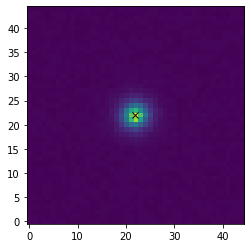

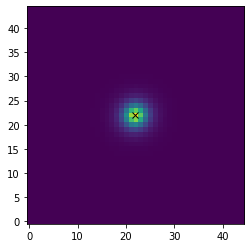

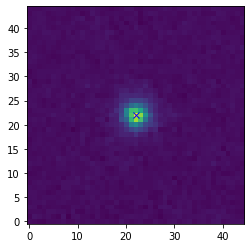

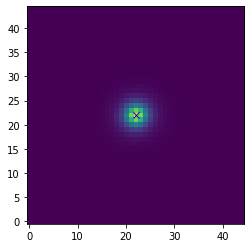

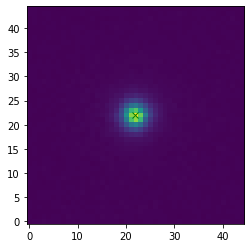

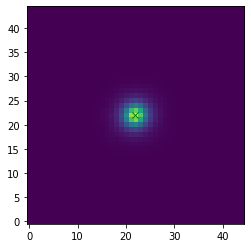

1.4572929
HE2233+0124
1.4572929
11 11
0.4
[0.22192845902593983, 10.971819278951788, 10.987154570494406, 0.16236413376010414, 0.15446541277413167, -0.020791415211415445, 3.285914582783939, 2.4286772865405855, 2.605597000603788, -0.603867040645246, 2.3539103609130962, 2.5253835946321597] [0.00639243 0.0175536  0.01931504 0.01781966 0.01753027 0.00565383
 0.24066616 0.13914757 0.15290666 0.45538189 0.04756951 0.05611883]
[ 0.13416613 10.99812878 11.00024412] [0.00716621 0.05979567 0.05648286]
[ 1.04974504 10.87221366 10.99017499] [0.0065138  0.00783745 0.0092694 ]


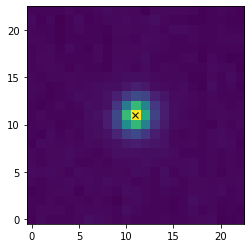

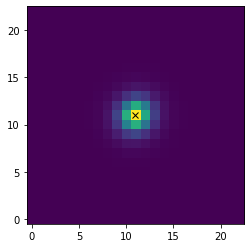

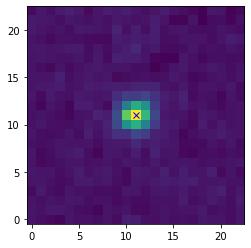

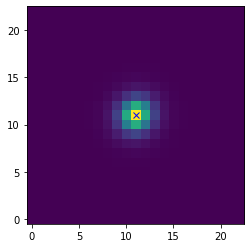

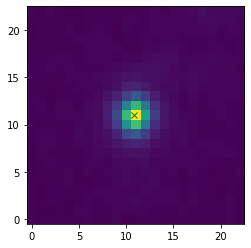

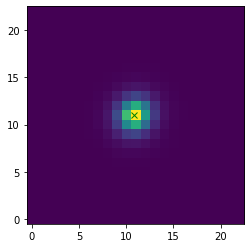

1.8749962
HE2302-0857
1.8749962
22 22
0.2
[1.0910742687504735, 22.162815348791398, 21.855084501546905, 0.10556914240749941, 0.09562398747263377, 0.010652736254046415, 2.553689152927994, 3.0445482343223, 3.2736808333657157, 0.4098683923367712, 3.400304878840461, 3.6562117111400485] [0.02672779 0.01674744 0.0165486  0.00407201 0.00372202 0.00117115
 0.03836707 0.05823608 0.06424972 0.04582455 0.03889377 0.0440607 ]
[ 1.14775163 22.69352663 21.95432333] [0.01568151 0.02649361 0.02189046]
[15.90696337 21.15945252 21.56417082] [0.01517187 0.00272735 0.00168624]


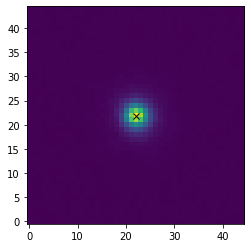

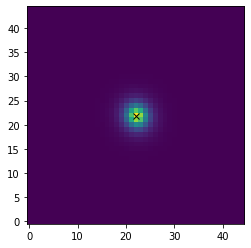

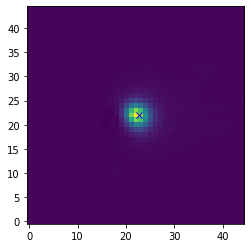

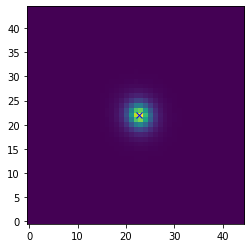

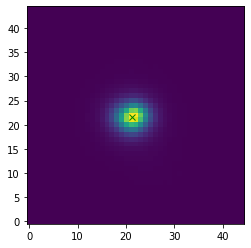

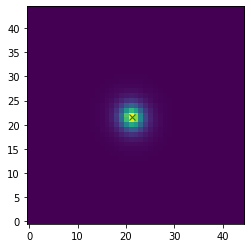

In [10]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}


objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

1.2778674
HE0021-1810
1.2778674
22 22
0.2
[0.039282929410594275, 22.763268793454735, 22.1541355069418, 0.08598969168204318, 0.07339897934630156, 0.009625840425187639, 2.2627595578135615, 3.3783261331514054, 3.7327477697747105, 0.326364389069139, 4.045131254046892, 4.469507700520401] [0.00312729 0.07569941 0.08136965 0.01811428 0.01575249 0.00662119
 0.19917181 0.34466609 0.36985471 0.3519691  0.22912852 0.24340789]
[ 0.23898183 22.16895241 21.82395049] [0.00100572 0.01271177 0.0119447 ]
[ 0.4139153  22.69155761 22.15019338] [0.00195337 0.0097467  0.01041884]


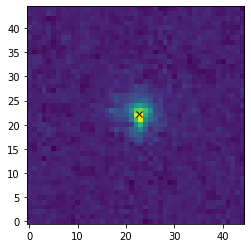

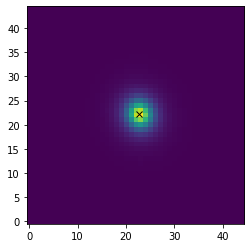

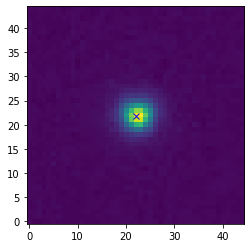

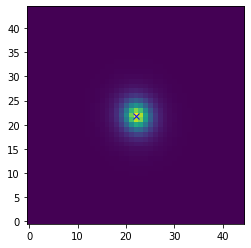

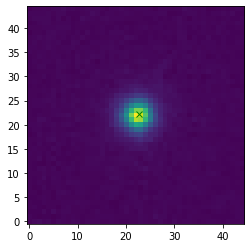

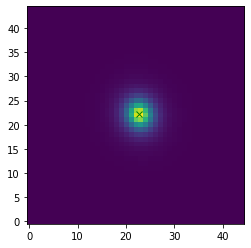

In [9]:
z = {"HE0021-1810":0.05352}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

In [2]:
21.63782717011039, 22.119457979406324

In [3]:
x,y

(144.55722116538186, 154.91615464190022)

In [15]:
169.9*4.848*0.2*np.sqrt((21.65 - 22.18)**2 + (21.68-21.81)**2)

89.89764862137467